In [5]:
import requests
from requests.auth import HTTPBasicAuth
from bs4 import BeautifulSoup
import re
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime


## Funciones

In [6]:
def carga_html(url):
  """
  Carga el html de cualquier página y lo parsea con soup
  """
  page = requests.get(url)
  
  if page.status_code == 200:

    soup = BeautifulSoup(page.content, "html.parser")
    return page.status_code,soup
  else: 
    print('Error %i: No se puede acceder'%page.status_code)
    return page.status_code, []

def carga_ema_wundermap_diario(url,year,month,day):
  """
  Carga la tabla de una ema de wundermap para dìa
  """
  url = '%s/table/%s-%s-%s/%s-%s-%s/daily'%(url,year,month,day,year,month,day)
  print(url)
  
  res,soup = carga_html(url)

  if res!=200: 
    print('Hay un error en los datos ingresados, o no existe la ema en wunderground')
    
  else:
    return carga_tabla_ema_wundermap(soup)

    
  time.sleep(0.3)

def carga_tabla_ema_wundermap(soup):

  tabla_gral = soup.find_all('table',attrs={'class':'history-table desktop-table'})[0]
  datos_tabla = tabla_gral.find_all('tr','ng-star-inserted')

  columnas = [col.text for col in tabla_gral.find_all('th') ]

  filas = []
  tiempo = []
  t,td,hr,v_dir,v_sp,rafagas,p,pp_rate,pp_acum = [],[],[],[],[],[],[],[],[]
  for fila in datos_tabla:

    datos = [dato.text for dato in fila.find_all('td')]
    datos = ['.'.join(re.findall(r'\d+', dato)) for dato in datos]
    
    filas.append(datos)
    tiempo.append(str(datos[0]))
    t.append(float(datos[1]))
    td.append(float(datos[2]))
    hr.append(float(datos[3]))
    v_dir.append(datos[4])
    v_sp.append(float(datos[5]))
    rafagas.append(float(datos[6]))  
    p.append(float(datos[7]))  
    pp_rate.append(float(datos[8]))  
    pp_acum.append(float(datos[9]))  

  df = pd.DataFrame(filas,columns=columnas)

  return df,tiempo,t,td,hr,v_dir,v_sp,rafagas,p,pp_rate,pp_acum



def set_tiempo(tiempo_1,tiempo_2):
  """
  PRE: Dados dos días secuencias de tiempo de días consecutivos
  POST: Devuelve una secuencia de 24 hs de 9hs a 9hs (12Z a 12Z del día siguiente), el índice inicial y el índice final
  """

  tiempo = tiempo_1
  tiempo.extend(tiempo_2)

  tiempo_acotado =[]
  ini = -1
  count_9 =0
  count_12 =0
  end = 0
  for i in range(len(tiempo)):
    tie=tiempo[i].split('.')[0]
    if count_9 == count_12 and tie == '9' :
      count_9 +=1
      if count_9==1:
        ini = i
    elif count_12 !=count_9 and tie =='12':
      count_12+=1
    if count_9 ==3: 
      end =i
      break

  tiempo_acotado = tiempo[ini:end]       
  return tiempo_acotado, ini, end

def set_pp(pp_acum_1,pp_acum_2,pp_rate_1,pp_rate_2,ini,end):
  pp_acum = pp_acum_1
  pp_acum.extend(pp_acum_2)
  pp_rate = pp_rate_1
  pp_rate.extend(pp_rate_2)


  pp_acum_acot = pp_acum[ini:end]
  pp_rate_acot = pp_rate[ini:end]

  return pp_acum_acot,pp_rate_acot

def set_pp_acum(pp_acum):
  """
  PRE: Dada una secuencia de pp acumulada
  POST:Devuelve la misma secuencia pero sin reseteo de la pp

  """
  dif_pp = 0
  for i in range(len(pp_acum)):  
    max_pp = 0
    if i>0 and pp_acum[i]<pp_acum[i-1]: 
        dif_pp = pp_acum[i-1]-pp_acum[i]
    pp_acum[i] += dif_pp 
    max_pp =pp_acum[i]

  return pp_acum
 

def cargar_periodo(tiempo, periodo):
    """
    PRE   Dados una secuencia de tiempos acotado (12z a 12z) y un periodo deseado ('sol' día o 'luna' noche) 
    POST  Devuelve los indices donde se encuentra la subsecuencia del periodo deseado
    """
    ini = -1
    end = -1

    if periodo =='sol':
      count_9 = 1
      at_9 = False
      at_12 = True

      for i,t in enumerate(tiempo):
        tie=t.split('.')[0]
        
        if tie=='9' and not at_9 and at_12:
            if ini == -1:
              ini = i
              at_9 = True
              at_12 = False
            else:
              end = i
              break  
        else:
            if tie =='12' and not at_12 and at_9:
              at_12 = True
              at_9 = False
              count_9 = 1

    elif periodo == 'luna':
      count_9 = 2
      at_9,at_12 = True,False
      for i,t in enumerate(tiempo):
        tie=t.split('.')[0]
      
        if tie=='9' and at_12 and not at_9:
              if ini == -1:
                ini = i      
                at_12 = False
                at_9 = True  
              else:
                end = i
                break       
        else:
          if tie =='12' and not at_12:
            at_12 = True
            at_9 = False      
    if end ==-1: end = len(tiempo)-1
    print(tiempo[ini],tiempo[end],ini,end)

    return ini,end

def cargar_dias_pp(url,fecha_ini,fecha_end):
  """
  PRE  Dada una url, una fecha de inicio y una fecha de fin (Se ingresan las fechas en formato AÑO-MES-DIA)
  POST Devuelve una lista de secuencias acotadas de tiempo, pp acumulada y tasa de pp separadas en día y noche para todos los días solicitados
  
  """
  time = []
  pp_acum_tot = []
  pp_acum_prev = 0
  pp_rate_tot = []
  periodos = ['sol','luna']

  for date in lista_dias(fecha_ini,fecha_end):
    
    month,_ = month_format(date)
    year = date.year
    day_1,day_2 = days_format(date)

    #Se pueden cargar todas las variables con t,td,hr,v_dir,v_sp,rafagas,p,pp_rate,pp_acum despues de tiempo o *_ si no se usan
    df_1,tiempo_1,*variables,pp_rate_1,pp_acum_1 = carga_ema_wundermap_diario(url,year,month,day_1)
    
    #Se pueden cargar todas las variables con t,td,hr,v_dir,v_sp,rafagas,p,pp_rate,pp_acum despues de tiempo o *_ si no se usan
    df_2,tiempo_2,*variables,pp_rate_2,pp_acum_2 = carga_ema_wundermap_diario(url,year,month,day_2)
    
    tiempo_acotado, ini, end = set_tiempo(tiempo_1,tiempo_2)


    pp_acum_acot,pp_rate_acot = set_pp (pp_acum_1,pp_acum_2,pp_rate_1,pp_rate_2,ini,end)




    ini,end = cargar_periodo(tiempo_acotado,'sol')
    time.append(list(date.replace(hour=int(tie.split('.')[0]), minute=int(tie.split('.')[1])) for tie in tiempo_acotado[ini:end]))
    pp_ini = pp_acum_acot[ini]
    pp_acum_period = set_pp_acum(np.array(pp_acum_acot[ini:end])-pp_ini)
    pp_acum_tot.append(pp_acum_period)
    pp_rate_tot.append(pp_rate_acot[ini:end])
    

    ini,end = cargar_periodo(tiempo_acotado,'luna')
    time.append(list(date.replace(hour=int(tie.split('.')[0]), minute=int(tie.split('.')[1])) for tie in tiempo_acotado[ini:end]))
    pp_ini = pp_acum_acot[ini]
    pp_acum_period = set_pp_acum(np.array(pp_acum_acot[ini:end])-pp_ini)
    pp_acum_tot.append(pp_acum_period)
    pp_rate_tot.append(pp_rate_acot[ini:end])
    

  return time,pp_acum_tot,pp_rate_tot



def lista_dias(fecha_ini,fecha_end):
  """
  PRE  Dadas una fecha inicial y una final
  POST Devuelve una tupla con los días formateados en ese rango
  """
  a = str_to_date(fecha_ini)
  b = str_to_date(fecha_end)
  delta = b - a
  return tuple(aumentar_dia(a,i) for i in range(delta.days))
  

def aumentar_dia(fecha_date,dias=1):
  """
  PRE  Dada una fecha y un delta de días
  POST Devuelve la fecha + la cantidad de días
  """
  return fecha_date + datetime.timedelta(days=dias)

def str_to_date(fecha_str,date_format = "%Y-%m-%d"):
  """
  PRE  Dada una fecha en texto y un formato de fecha
  POST Devuelve la fecha en ese formato
  """
  return datetime.datetime.strptime(fecha_str, date_format)
def days_format(date):
  """
  PRE  Dada una fecha
  POST Devuelve el mismo día y el siguiente
  """
  return date.day, aumentar_dia(date,1).day

def month_format(date):
  """
  PRE  Dada una fecha
  POST Devuelve el mes de esa fecha y el del siguiente día
  """
  return date.month, aumentar_dia(date,1).month



## CARGO LOS DATOS DE WUNDERMAP PARA UNA ESTACIÓN Y FECHAS

In [8]:
#url = 'https://www.wunderground.com/dashboard/pws/IBUENOSA236'
#/table/2021-09-8/2021-09-8/daily
url = 'https://www.wunderground.com/dashboard/pws/IBUENOSA90'

tiempo, pp_acum,pp_rate = cargar_dias_pp(url,'2021-09-07','2021-09-09')

https://www.wunderground.com/dashboard/pws/IBUENOSA90/table/2021-9-7/2021-9-7/daily
https://www.wunderground.com/dashboard/pws/IBUENOSA90/table/2021-9-8/2021-9-8/daily
9.04 9.04 0 144
9.04 8.59 144 287
https://www.wunderground.com/dashboard/pws/IBUENOSA90/table/2021-9-8/2021-9-8/daily
https://www.wunderground.com/dashboard/pws/IBUENOSA90/table/2021-9-9/2021-9-9/daily
9.04 9.04 0 144
9.04 8.59 144 287


# Ploteo de PP

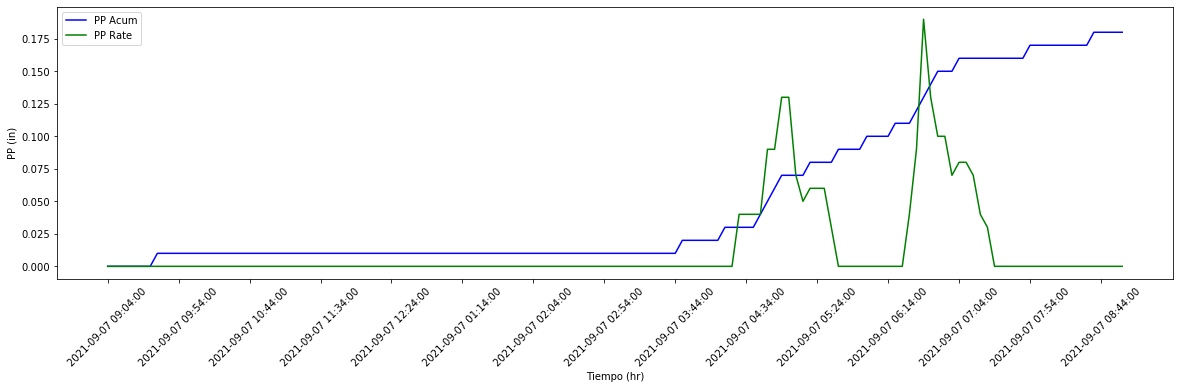

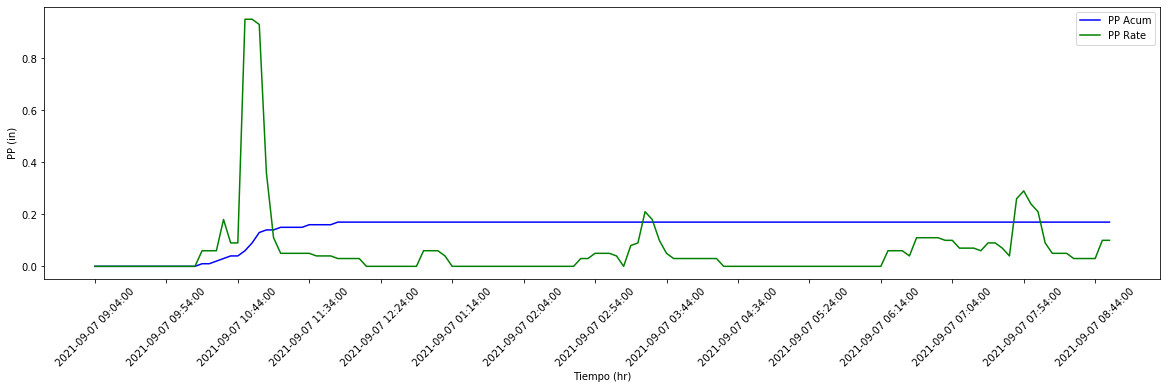

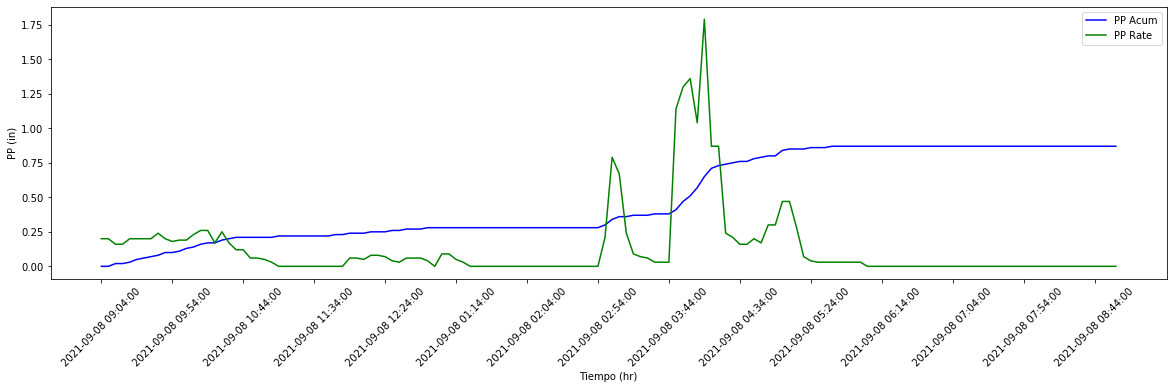

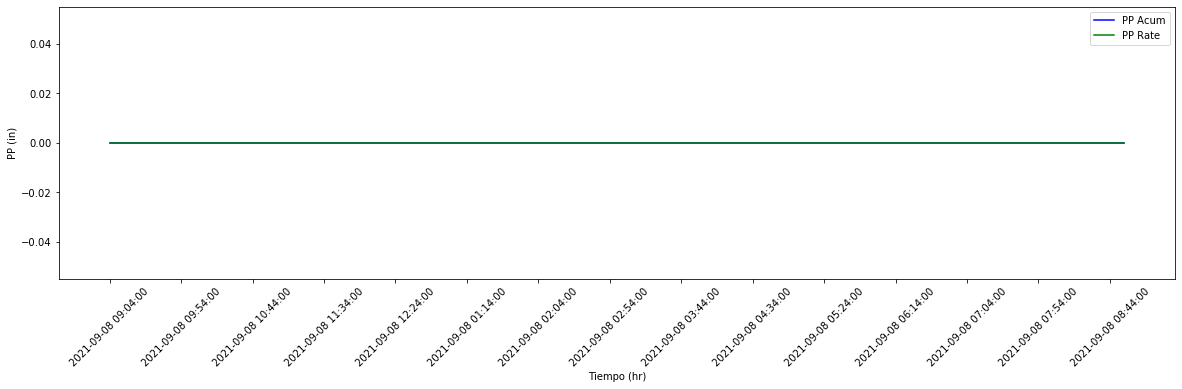

In [9]:
for i, tie in enumerate(tiempo):

  pp_ini = pp_acum[i][0]
  x = [i for i in range(len(tie))]
  fig = plt.figure(figsize=(20,5))
  plt.subplot()
  plt.xticks(x[::10],tie[::10],rotation=45)
  plt.ylabel('PP (in)')
  plt.xlabel('Tiempo (hr)')
  plt.plot(x,np.array(pp_acum[i]),label='PP Acum',color='b')
  plt.plot(x,pp_rate[i],label='PP Rate',color='g')
  plt.legend()
  plt.show()